# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

In [1]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

from scipy.sparse import csr_matrix

In [2]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(2020, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

2023-12-01 17:29:08.939 | INFO     | preprocessing:__init__:56 - --- Executing Preprocessing Steps ---
2023-12-01 17:29:08.940 | INFO     | preprocessing:make_combined_df:151 - Loading csv files
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:156: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:156: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:156: DtypeWarning: Columns (179,180,182,183,189,190,193,

### General functions

In [3]:
def split_feature_target(df, data_fraction=1):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    features = df_sampled.drop(TARGET_NAME, axis=1)
    target = df_sampled[TARGET_NAME]

    return features, target

def visualize_predicts(y_test, predictions, label):
    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title('Pass Model: True vs Predicted Yards - ' + label)
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def visualize_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

### Functions for cross validation

In [4]:
def test_model(pipeline, x_train, y_train, x_test, y_test):
    pipeline.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(x_test)

    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")
    return predictions

def test_model_k_fold(df, pipeline, data_fraction, k_folds=5):
    features, target = split_feature_target(df, data_fraction)
    
    cv_results = cross_val_predict(pipeline, features, target, cv=k_folds)
    #print(f"Run Model Cross-Validation Mean Squared Error: {np.mean(cv_results)}")
    #print(f"Run Model Cross-Validation Max Squared Error: {np.max(cv_results)}")
    return cv_results

def estimate_hyperparams(features, target, pipeline, data_fraction, scoring, k_folds=5, parameters={}):

    # specify the cross validation
    # stratified_k_fold_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)

    return grid_search_estimator

### MLP Regressor with history

In [5]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

### Train and Test Data

In [6]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)


(51020, 28)
(64625, 28)


### Linear Regression

In [9]:
training_df = pd.DataFrame({'a': np.random.randint(100, size=100), 'b': np.random.randint(100, size=100)})
target = pd.DataFrame({'y': np.random.randint(100, size=100)})

training_df = training_df.loc[
                        ~(
                            (training_df['a'] < 30)
                            | (training_df['a'] > 60)
                        )
                    ]


missing_rows = target.index.difference(training_df.index)
target = target.drop(index=missing_rows)


In [7]:
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['posteam', 'posteam_type',
                                                   'defteam', 'roof',
                                                   'season_type']),
                                                 ('outlier_remover',
                                                  FunctionSampler(func=<bound method NFLPreprocessing.outlier_sampler_iqr of <preprocessing.NFLPreprocessing object at 0x000...
                                                   'score_differential']),
                                                 ('standardization',
                                                  StandardScaler(),
                                                  ['score_differential']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['yardline_100',
                                                   'game_seconds_remaining',
                                                   'down', 'ydstogo', 'td_prob',
                                                   'spread_line', 'total_line',
                                                   'season',
                                                   'posteam_timeouts_remaining',
                                                   'defteam_timeouts_remaining',
                                                   'quarter_seconds_remaining',
                                                   'half_seconds_remaining',
                                                   'drive_start_yard_line'])]))])

In [8]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("regression", LinearRegression()))
pass_pipeline.steps.append(("regression", LinearRegression()))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. 'FunctionSampler(func=<bound method NFLPreprocessing.outlier_sampler_iqr of <preprocessing.NFLPreprocessing object at 0x0000016A8135F410>>,
                validate=False)' (type <class 'imblearn.base.FunctionSampler'>) doesn't.

In [14]:
# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("regression", LinearRegression()))
pass_pipeline.steps.append(("regression", LinearRegression()))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")


Run Model Cross-Validation Mean Squared Error: 40.10367636877511


### Polynomial Regression

In [13]:
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['posteam', 'posteam_type',
                                                   'defteam', 'roof',
                                                   'season_type']),
                                                 ('outlier_remover',
                                                  Pipeline(steps=[('outlier_remover',
                                                                   FunctionSampler(func=<bound method NFLPreprocessing.outlier_sampler_iqr of <preprocessing.NFLPreprocessing ob...
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['score_differential']),
                                                 ('minmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['yardline_100',
                                                   'game_seconds_remaining',
                                                   'down', 'ydstogo', 'td_prob',
                                                   'spread_line', 'total_line',
                                                   'season',
                                                   'posteam_timeouts_remaining',
                                                   'defteam_timeouts_remaining',
                                                   'quarter_seconds_remaining',
                                                   'half_seconds_remaining',
                                                   'drive_start_yard_line'])]))])

Mean Squared Error: 41.72882445102919
Mean Absolute Error: 4.141732605260445
Root Mean Squared Error: 6.459785170656157
Mean Squared Error: 104.42414908037658
Mean Absolute Error: 7.309790456417346
Root Mean Squared Error: 10.218813486916012


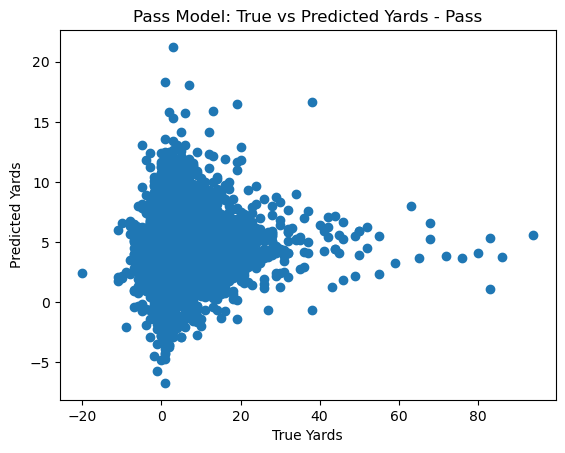

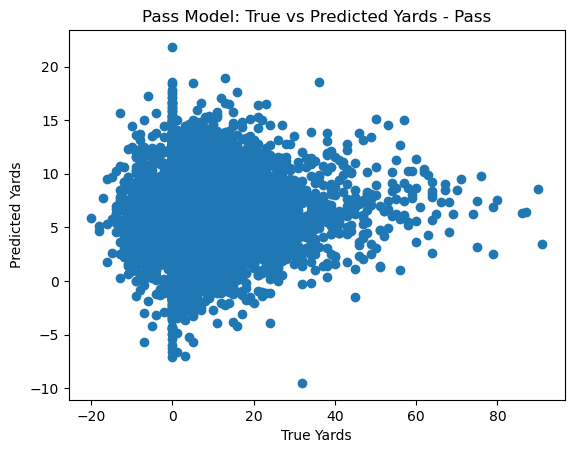

In [16]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("regression", make_pipeline(PolynomialFeatures(2), LinearRegression())))
pass_pipeline.steps.append(("regression", make_pipeline(PolynomialFeatures(2), LinearRegression())))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [171]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = make_pipeline(PolynomialFeatures(), LinearRegression())
pass_model = make_pipeline(PolynomialFeatures(), LinearRegression())

parameters = {
    'polynomialfeatures__degree': [2, 3]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'polynomialfeatures__degree': 3}

{'polynomialfeatures__degree': 3}

In [172]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", make_pipeline(
    PolynomialFeatures(degree=run_estimator.best_params_['polynomialfeatures__degree']), 
    LinearRegression()
)))
pass_pipeline.steps.append(("regressor", make_pipeline(
    PolynomialFeatures(degree=pass_estimator.best_params_['polynomialfeatures__degree']), 
    LinearRegression()
)))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 136.11672497702932


KeyboardInterrupt: 

### KNN

Mean Squared Error: 53.121034785227074
Mean Absolute Error: 4.710576960842072
Root Mean Squared Error: 7.28841785199141
Mean Squared Error: 128.6831383400002
Mean Absolute Error: 8.149267647147283
Root Mean Squared Error: 11.343859058539126


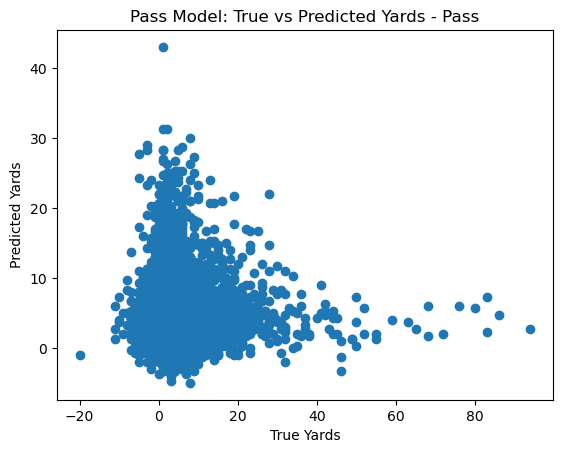

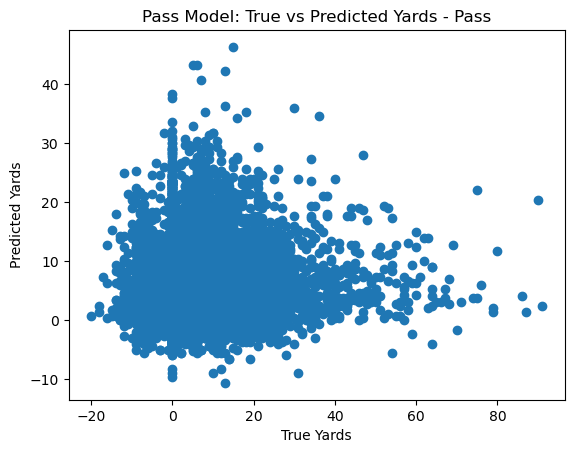

In [17]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# append KNeighborsRegressor to pipeline
run_pipeline.steps.append(("regression", KNeighborsRegressor(n_neighbors=3)))
pass_pipeline.steps.append(("regression", KNeighborsRegressor(n_neighbors=3)))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [166]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.1)
pass_features, pass_target = split_feature_target(pass_df, 0.1)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = KNeighborsRegressor()
pass_model = KNeighborsRegressor()

parameters = {
    'n_neighbors': range(1, 10)
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'n_neighbors': 9}

{'n_neighbors': 9}

In [168]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", KNeighborsRegressor(run_estimator.best_params_['n_neighbors'])))
pass_pipeline.steps.append(("regressor", KNeighborsRegressor(pass_estimator.best_params_['n_neighbors'])))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 41.15833694740799
Run Model Cross-Validation Mean Squared Error: 98.96113022019077


### Random Forest

Mean Squared Error: 37.983845652396674
Mean Absolute Error: 3.8016131915468176
Root Mean Squared Error: 6.163103573070687
Mean Squared Error: 96.4104762293561
Mean Absolute Error: 6.985704738057918
Root Mean Squared Error: 9.81888365494551


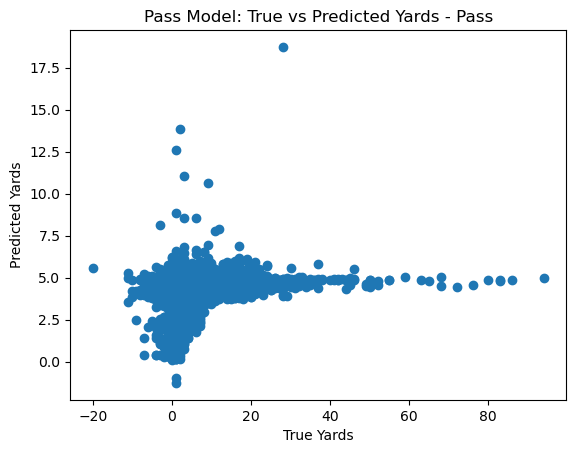

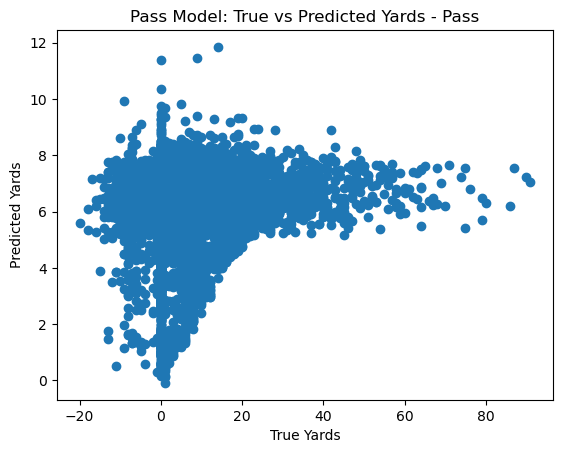

In [18]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)))
pass_pipeline.steps.append(("regressor", RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [42]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = RandomForestRegressor()
pass_model = RandomForestRegressor()

parameters = {
    'max_depth': range(4, 7),
    'n_estimators': [20, 50, 100]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'max_depth': 5, 'n_estimators': 50}

{'max_depth': 6, 'n_estimators': 100}

In [176]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", RandomForestRegressor(
    max_depth=run_estimator.best_params_['max_depth'],
    n_estimators=run_estimator.best_params_['n_estimators'],
)))
pass_pipeline.steps.append(("regressor", RandomForestRegressor(
    max_depth=pass_estimator.best_params_['max_depth'],
    n_estimators=pass_estimator.best_params_['n_estimators'],
)))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 34.503509110877765
Pass Model Cross-Validation Mean Squared Error: 60.60760821554169


Mean Squared Error: 34.46531108497991
Mean Absolute Error: 4.178915907783001
Root Mean Squared Error: 5.870716403044854
Mean Squared Error: 60.303978152894274
Mean Absolute Error: 5.430703308382625
Root Mean Squared Error: 7.76556360819318


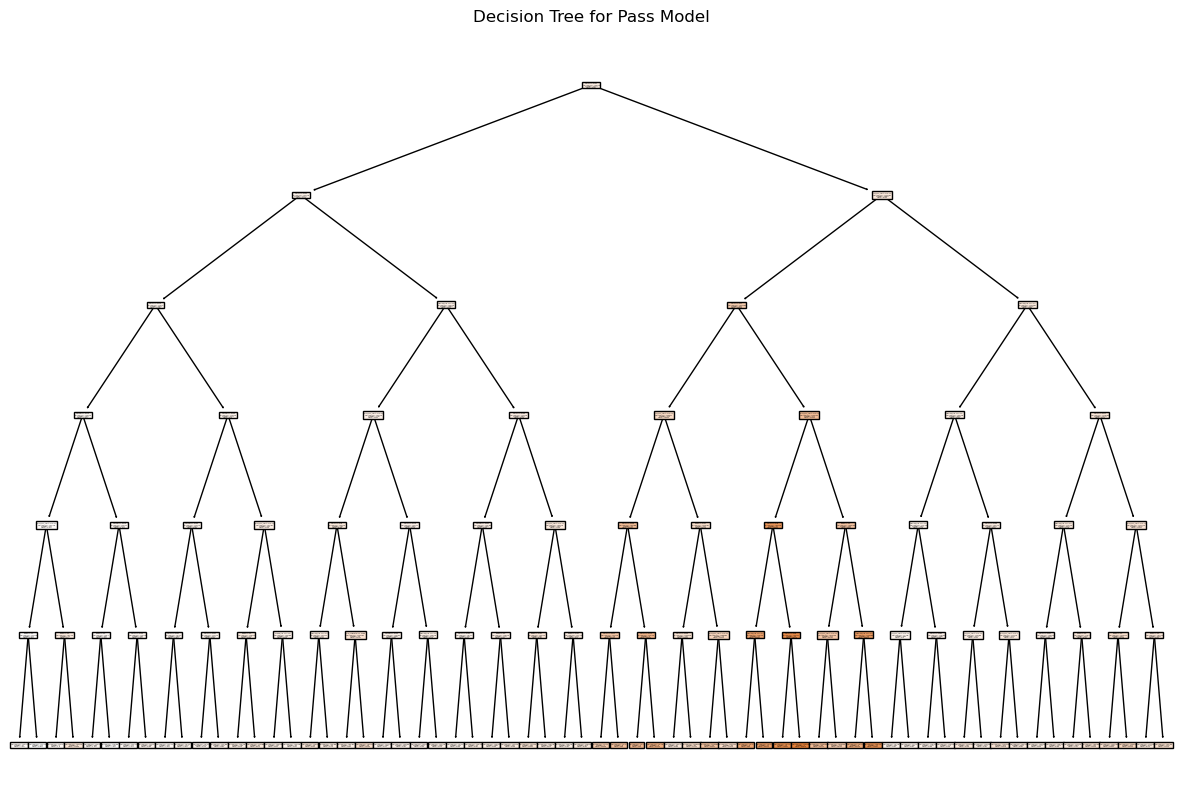

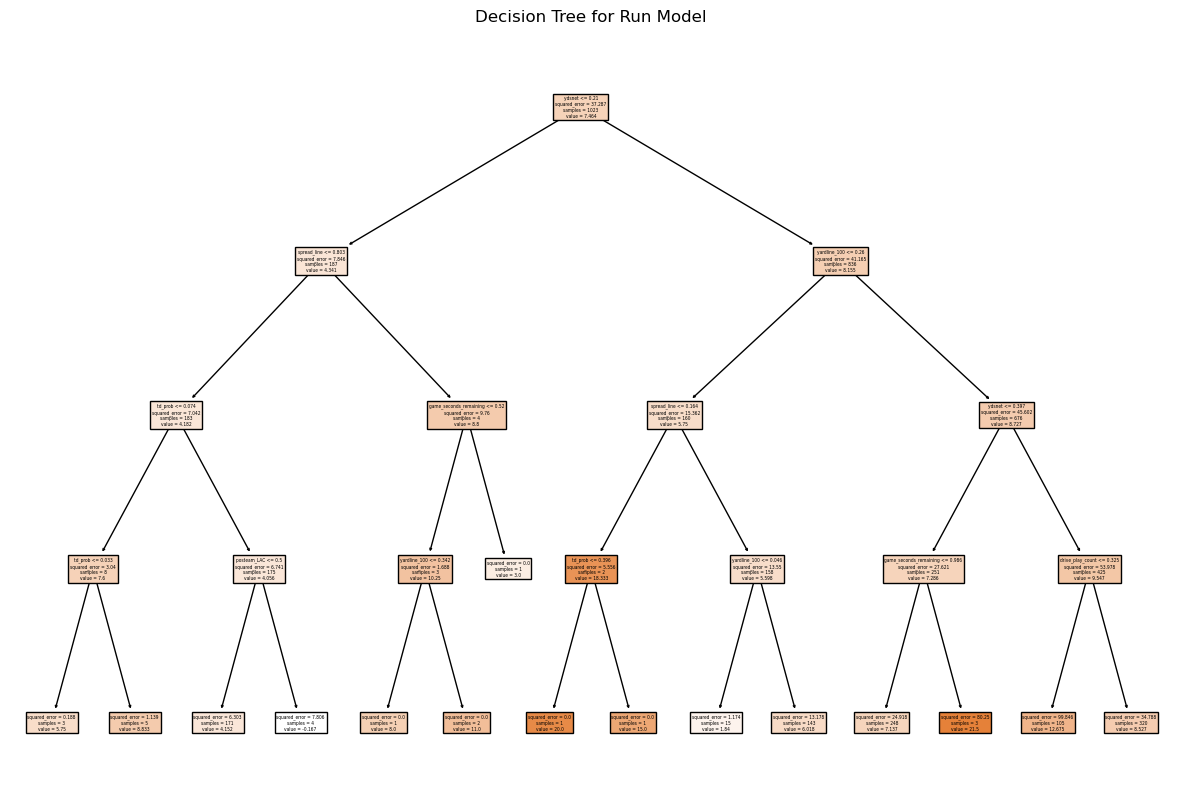

In [181]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### Artificial Neuronal Network

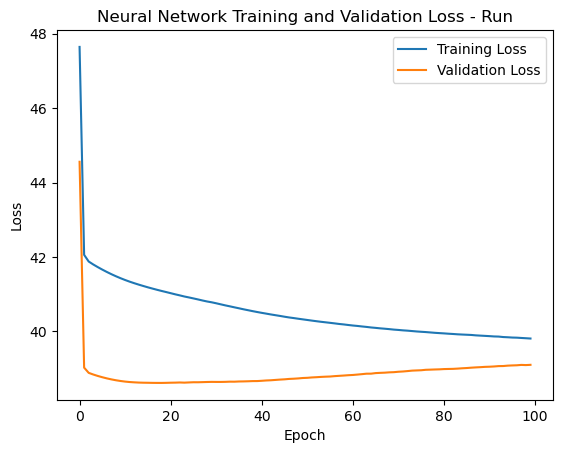

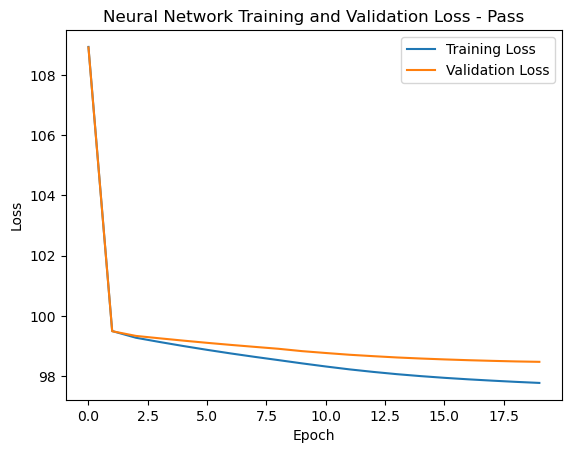

Mean Squared Error (MSE) for run plays: 39.04907203802989
Mean Squared Error (MSE) for pass plays: 97.97378160984717


In [10]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(('regressor', MLPWithHistory(mlp_params={'hidden_layer_sizes': (10, ), 'max_iter': 100, 'solver': 'adam', 'activation': 'relu', 'random_state': 42})))
pass_pipeline.steps.append(('regressor', MLPWithHistory(mlp_params={'hidden_layer_sizes': (10, ), 'max_iter': 20, 'solver': 'adam', 'activation': 'relu', 'random_state': 42})))

# Fit the pipelines
run_pipeline.fit(run_X_train, run_y_train)
pass_pipeline.fit(pass_X_train, pass_y_train)

run_mlp = run_pipeline.named_steps['regressor']
pass_mlp = pass_pipeline.named_steps['regressor']

# Plot the training and validation loss
visualize_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)
visualize_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

# Evaluate the neural network for run plays
y_run_pred = run_pipeline.predict(run_X_test)
mse_run = mean_squared_error(run_y_test, y_run_pred)
print(f"Mean Squared Error (MSE) for run plays: {mse_run}")

# Evaluate the neural network for pass plays
y_pass_pred = pass_pipeline.predict(pass_X_test)
mse_pass = mean_squared_error(pass_y_test, y_pass_pred)
print(f"Mean Squared Error (MSE) for pass plays: {mse_pass}")


In [9]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = MLPWithHistory()
pass_model = MLPWithHistory()

parameters = {
    'mlp_params': [
        {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    ]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'mlp_params': {'hidden_layer_sizes': (10,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

{'mlp_params': {'hidden_layer_sizes': (10,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

### XGBoost

Mean Squared Error: 38.41531973264254
Mean Absolute Error: 3.7470275972466665
Root Mean Squared Error: 6.198009336282299
Mean Squared Error: 99.81018730789826
Mean Absolute Error: 7.0483106707653755
Root Mean Squared Error: 9.990504857508366


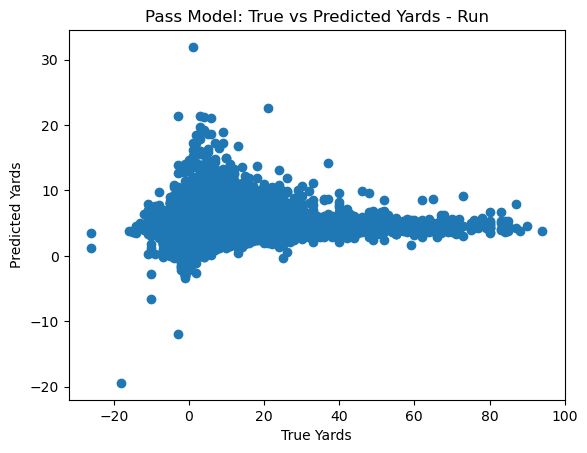

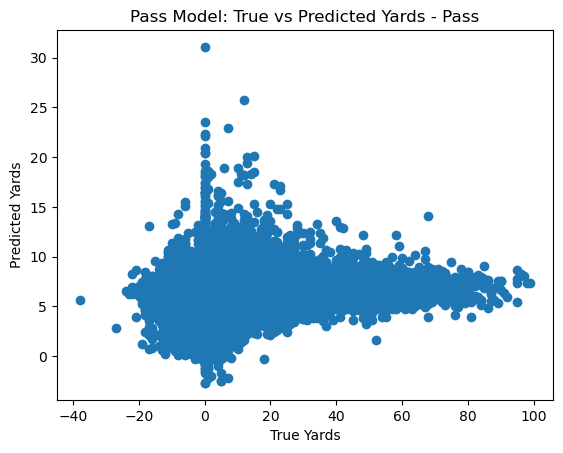

In [24]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("gradientBoosting", xgb.XGBRegressor(learning_rate = 0.022,
                           n_estimators  = 1000,
                           max_depth     = 8,
                           eval_metric='rmsle')))
pass_pipeline.steps.append(("gradientBoosting", xgb.XGBRegressor(learning_rate = 0.015,
                           n_estimators  = 1000,
                           max_depth     = 8,
                           eval_metric='rmsle')))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [22]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.001)
pass_features, pass_target = split_feature_target(pass_df, 0.001)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = xgb.XGBRegressor()
pass_model = xgb.XGBRegressor()

parameters = {"max_depth":    [8, 10],
              "n_estimators": [1000, 1100],
              "learning_rate": [0.022, 0.015]}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'learning_rate': 0.022, 'max_depth': 8, 'n_estimators': 1000}

{'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 1000}